In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataframes = []

In [3]:
# Get a list of all CSV files in the current directory
csv_files = glob.glob('open-data_aww-*.csv')

# Loop through the files and read them into dataframes
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

# Combine the dataframes into one
combined_data = pd.concat(dataframes, ignore_index=True)

In [4]:
combined_data.shape

(30708, 5)

In [5]:
# Display the first few rows of the dataset
combined_data.head()

,Month Observed,Year Observed,Species,Latitude,Longitude
0,January,2016,"Deer, White-Tailed",57.147963,-111.587578
1,January,2016,"Deer, White-Tailed",56.800923,-111.435825
2,January,2016,"Deer, White-Tailed",55.172016,-112.480026
3,January,2016,"Deer, White-Tailed",56.392280,-111.443014
4,January,2016,Duck/Goose/Swan,56.711200,-111.385400


In [6]:
# Checking the column names in the DataFrame 
print(combined_data.columns)

Index([' Month Observed', ' Year Observed', ' Species', ' Latitude',
       ' Longitude'],
      dtype='object')


In [7]:
# Remove leading and trailing white spaces from all column names
combined_data.columns = combined_data.columns.str.strip()

# Exploratory Data Analysis

In [8]:
# Starting off by computing basic summary statistics Latitude and Longitude
# This could provide valuable insights about the geographic distribution of wildlife-vehicle collisions
print(combined_data[['Latitude', 'Longitude']].describe())

# mean represents average geographic location of the incidents
# standard deviation could help indicate the spread or variability of incidents from the mean
# min/max values would represent the range of Latitudes/Longitudes where incidents occurred
# This information could be useful for spatial analysis and visualization, helping identify hotspots or trends in the data.

           Latitude     Longitude
count  30708.000000  30708.000000
mean      52.087727   -113.754848
std        1.851877      1.863956
min       49.003684   -119.997728
25%       50.735407   -114.375951
50%       52.026814   -113.651903
75%       53.569995   -112.666804
max       59.214230   -110.012259


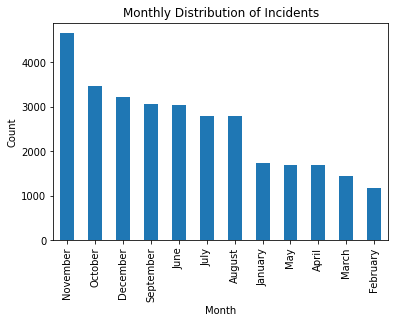

In [9]:
# Calculate the count of incidents for each month
monthly_counts = combined_data['Month Observed'].value_counts()

# Create a bar plot to visualize the monthly distribution of incidents
monthly_counts.plot(kind='bar')

# Add a title and labels to the plot
plt.title('Monthly Distribution of Incidents')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

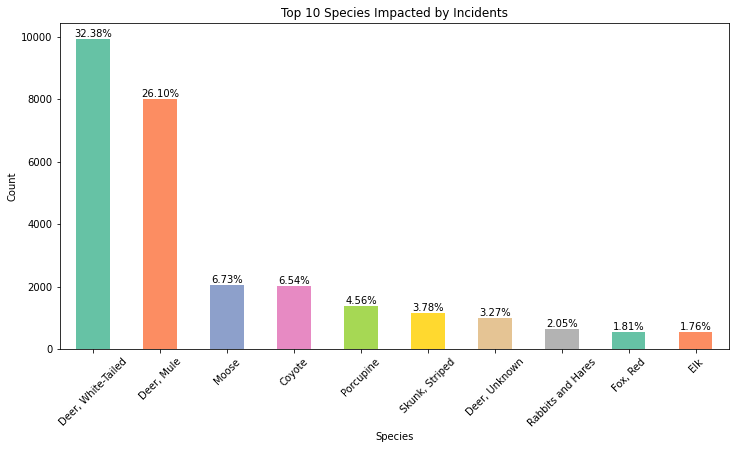

In [10]:
"""
Next visualizing the top 10 species impacted by incidents in a bar chart. 
The count of incidents for each species are shown along with the percentage of each species relative 
to the total observations above the bars for better insight into the data.

"""

# Calculate the count of incidents for each species
species_counts = combined_data['Species'].value_counts()

# Select the top 10 species by incident count
top_10_species = species_counts.head(10)

# Calculate the total number of observations (total species count)
total_observations = len(combined_data)

# Calculate the percentage of each species with respect to the total observations
species_percentage = (top_10_species / total_observations) * 100

# Set a custom color palette
custom_colors = sns.color_palette("Set2")

# Create a larger bar plot to visualize the top 10 impacted species with percentages
plt.figure(figsize=(12, 6))  # Adjust the figure size for better readability
ax = top_10_species.plot(kind='bar', color=custom_colors)
plt.title('Top 10 Species Impacted by Incidents')
plt.xlabel('Species')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

# Display the percentage on a separate line above the bar
for i, val in enumerate(top_10_species):
    ax.text(i, val + 5, f"{species_percentage[i]:.2f}%", ha='center', va='bottom', fontsize=10, color='black')

plt.show()

<Figure size 1008x576 with 0 Axes>

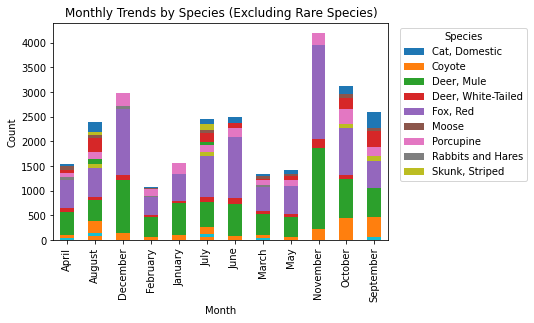

In [11]:
# Group the data by month and species to count occurrences
monthly_species_counts = combined_data.groupby(['Month Observed', 'Species']).size().unstack().fillna(0)

# Calculate the total count of incidents for each month
monthly_total_counts = monthly_species_counts.sum(axis=1)

# Determine the threshold (2% of the total count)
threshold = 0.02 * monthly_total_counts

# Exclude species that make up less than 1% of the total count for a month
for month in monthly_species_counts.index:
    species_counts = monthly_species_counts.loc[month]
    species_counts[species_counts < threshold[month]] = 0

# Create a larger stacked bar chart to visualize species by month
plt.figure(figsize=(14, 8))
ax = monthly_species_counts.plot(kind='bar', stacked=True)
plt.title('Monthly Trends by Species (Excluding Rare Species)')
plt.xlabel('Month')
plt.ylabel('Count')

# Filter and display only relevant species names in the legend
relevant_species = [species for species in species_counts.index if species_counts[species].sum() > 0]

# Specify the legend location and size
plt.legend(title='Species', labels=relevant_species, bbox_to_anchor=(1.02, 1), loc='upper left', prop={'size': 10})

plt.show()

# Clustering Algorithms

## HDBSCAN

Using HDBSCAN instead since DBSCAN can be sensitive to noise, potentially leading to the formation of spurious clusters. In contrast, HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise), addresses this limitation by prioritizing high-density clustering. 

<ipython-input-27-3b4840259980>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2022['Cluster'] = clusters


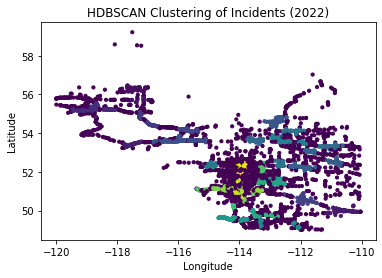

In [27]:
import pandas as pd
import hdbscan
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

df_2022 = combined_data[combined_data['Year Observed'] == 2022]

# Extract latitude and longitude as a NumPy array and normalize them
coordinates = df_2022[['Latitude', 'Longitude']].values
coordinates_normalized = StandardScaler().fit_transform(coordinates)

# Create and fit the HDBSCAN model
min_cluster_size = 5  
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean')
clusters = hdbscan_model.fit_predict(coordinates_normalized)

# Add the cluster labels to the DataFrame
df_2022['Cluster'] = clusters

# Plot the clusters on a scatter plot
plt.scatter(df_2022['Longitude'], df_2022['Latitude'], c=df_2022['Cluster'], cmap='viridis', s=10)
plt.title('HDBSCAN Clustering of Incidents (2022)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Hierarchical Clustering

Now trying out Hierarchical Clustering since the results obtained from HDBSCAN did not look promising. Hierarchical clustering builds a tree-like structure, capturing relationships between data points at various scales. This allows for the identification of clear and distinct clusters based on both global and local structures in the data. In contrast, HDBSCAN focuses on high-density regions, which may result in more emphasis on local structures and less sensitivity to global patterns.

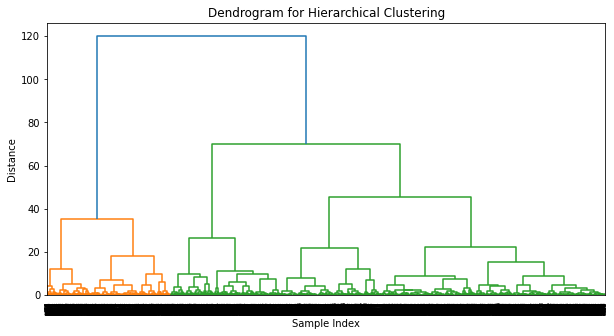

<ipython-input-29-2863afbe68a9>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2022['Cluster'] = clusters


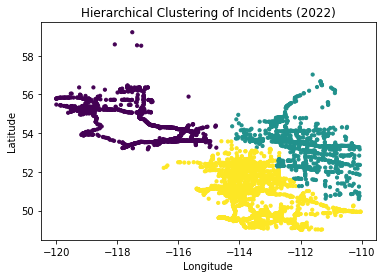

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler


df_2022 = combined_data[combined_data['Year Observed'] == 2022]

# Extract latitude and longitude as a NumPy array and normalize them
coordinates = df_2022[['Latitude', 'Longitude']].values
coordinates_normalized = StandardScaler().fit_transform(coordinates)

# Perform hierarchical clustering
linkage_matrix = linkage(coordinates_normalized, method='ward')

# Plot the dendrogram to help determine the number of clusters
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Based on the dendrogram, set the number of clusters
num_clusters = 3  # could be adjusted based on interpretation of the dendrogram

# Assign cluster labels
clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

# Add the cluster labels to the DataFrame
df_2022['Cluster'] = clusters

# Plot the clusters on a scatter plot
plt.scatter(df_2022['Longitude'], df_2022['Latitude'], c=df_2022['Cluster'], cmap='viridis', s=10)
plt.title('Hierarchical Clustering of Incidents (2022)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [30]:
df_2022.head()

,Month Observed,Year Observed,Species,Latitude,Longitude,Cluster
24030,January,2022,Badger,50.506142,-111.708952,3
24031,January,2022,"Caribou, Woodland",55.959766,-112.006788,2
24032,January,2022,"Cat, Domestic",50.407872,-113.827784,3
24033,January,2022,"Cat, Domestic",49.021144,-111.943972,3
24034,January,2022,"Cat, Domestic",49.962669,-113.084435,3


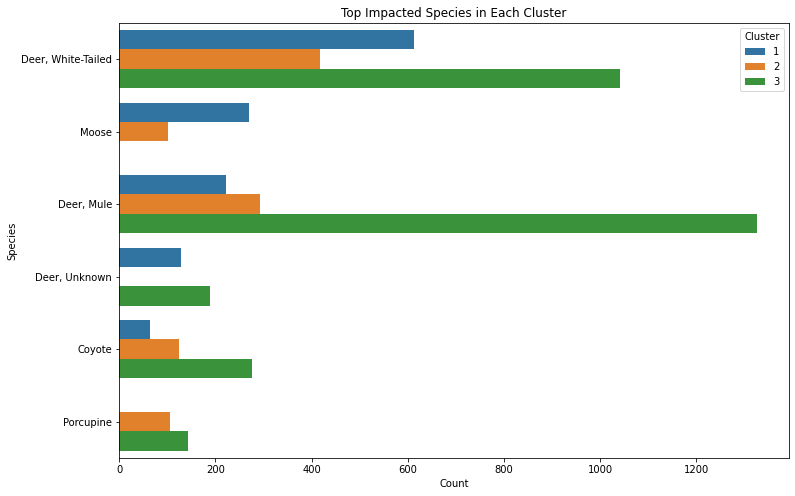

In [37]:
# Identify the top 5 impacted species in each cluster
top_5_impacted_species = df_2022.groupby(['Cluster', 'Species']).size().reset_index(name='Count')
top_5_impacted_species = top_5_impacted_species.sort_values(['Cluster', 'Count'], ascending=[True, False])
top_5_impacted_species = top_5_impacted_species.groupby('Cluster').head(5)

# Visualize the top 5 impacted species for each cluster using a bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Species', hue='Cluster', data=top_5_impacted_species)
plt.title('Top Impacted Species in Each Cluster')
plt.xlabel('Count')
plt.ylabel('Species')
plt.show()

In [38]:
# Calculate average latitude and longitude for each cluster
average_coords = df_2022.groupby('Cluster')['Latitude', 'Longitude'].mean().reset_index()

# Display the average latitude and longitude for each cluster
print("Average Latitude and Longitude for Each Cluster:")
print(average_coords)

Average Latitude and Longitude for Each Cluster:
   Cluster   Latitude   Longitude
0        1  54.504438 -117.123183
1        2  53.472509 -112.053730
2        3  50.949450 -113.623891


<ipython-input-38-5ae306dc3d15>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  average_coords = df_2022.groupby('Cluster')['Latitude', 'Longitude'].mean().reset_index()


Based on the average latitude and longitude values, below are the central locations for each cluster:

Cluster 1: Little Smoky (nearby large city: Grande Prairie)

Cluster 2: Vegreville (nearby large city: Edmonton)

Cluster 3: Lyalta (nearby large city: Calgary)